# Traffic Congestion Project
## Some Context

**Traffic congestion is a situation where the demand for road space exceeds the available supply, resulting in slower speeds, longer trip times, and increased delays.** It is a common problem in many cities and can have a negative impact on both individuals and society as a whole.

There are several reasons why traffic congestion has become a problem in many places:

1. **Population growth**: As cities grow, there are more people and vehicles on the road, which can lead to more congestion.

2. **Economic development**: As a city's economy grows and becomes more prosperous, there is often an increase in the number of vehicles on the road, which can contribute to congestion.

3. **Limited infrastructure**: In many cities, the roads and highways are not able to keep up with the demand for travel, leading to congestion.

4. **Poor transportation planning**: If a city does not have a well-designed transportation system that can handle the demand for travel, it is likely to experience congestion.

5. **Unforeseen events**: Accidents, construction, and other unexpected events can also contribute to congestion.

Traffic congestion can have a number of negative consequences, including **increased fuel consumption and air pollution, decreased productivity, and increased stress and frustration for drivers**. It can also have **economic impacts**, as businesses may experience delays in the delivery of goods and services due to congested roads.

**The aim of this project is to create a machine learning model able to predict the amount of congestion given certain variables.** Let's start!

# Final Model
#### MAE Score: 6.65
## Data Cleaning and Preprocessing


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Read the train csv file
df_train = pd.read_csv('train.csv', parse_dates=['date'])

# Drop transit column
df_nonas = df_train.drop('transit', axis = 1)

# Fill NAs with 0s
df_nonas = df_nonas.fillna(0)

# Drop outliers

def drop_outliers(df, column):
    # Calculate the IQR for the specified column
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    # Determine the lower and upper bounds for outliers
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    # Drop rows with outliers in the specified column
    df = df[(df[column] > lower_bound) & (df[column] < upper_bound)]

    return df

df_nooutliers = drop_outliers(df_nonas, 'congestion')
                                              
# Creating new columns 

df_final = df_nooutliers.assign(
    month_and_day=df_nonas['date'].dt.strftime('%m-%d'),
    month=df_nonas['date'].dt.strftime('%m'),
    day_of_week=df_nonas['date'].dt.strftime('%A')
)

# Average congestion for the weekday in the city
df_final['weekday_avg_congestion'] = df_final.groupby(['city', df_final['date'].dt.strftime('%A')])['congestion'].transform('mean')

# Average congestion for the same month (current and previous) in the city
df_final['month_avg_congestion'] = df_final.groupby(['city', df_final['date'].dt.strftime('%m')])['congestion'].transform('mean')

# Converting strings to categories

df_final['city'] = df_final['city'].astype('category').cat.codes
df_final['month'] = df_final['month'].astype('int')
df_final['day_of_week'] = df_final['day_of_week'].astype('category').cat.codes

df_final

,country,city,date,congestion,driving,walking,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,commercial,utilities,other,month_and_day,month,day_of_week,weekday_avg_congestion,month_avg_congestion
0,Austria,19,2019-12-30,23,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,97,50,1,12-30,12,1,27.079208,22.939394
1,Austria,39,2019-12-30,18,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,91,51,1,12-30,12,1,27.683168,23.393939
2,Belgium,7,2019-12-30,24,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,99,50,1,12-30,12,1,32.303030,26.818182
3,Belgium,11,2019-12-30,15,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,91,52,1,12-30,12,1,15.415842,14.060606
4,Czechia,6,2019-12-30,14,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,112,51,1,12-30,12,1,30.244898,22.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27875,Spain,27,2021-11-30,26,18.39,16.17,-6.0,13.0,2.0,-2.0,-12.0,2.0,106,51,1,11-30,11,5,16.623762,18.233333
27876,Spain,36,2021-11-30,24,10.57,-4.94,-6.0,11.0,-5.0,-6.0,-9.0,1.0,102,52,1,11-30,11,5,16.316832,17.750000
27877,Sweden,18,2021-11-30,43,21.97,39.40,-7.0,2.0,13.0,-16.0,-24.0,8.0,99,52,1,11-30,11,5,19.366337,18.400000
27878,Sweden,28,2021-11-30,23,21.83,21.07,-3.0,10.0,10.0,-19.0,-25.0,7.0,93,54,1,11-30,11,5,16.811881,15.666667


In [2]:
df_final.corr()['congestion'].sort_values(ascending=False, key = abs)

congestion                1.000000
weekday_avg_congestion    0.733296
month_avg_congestion      0.593087
retail_and_recreation     0.395104
transit_stations          0.356079
grocery_and_pharmacy      0.343934
driving                   0.327545
walking                   0.280562
residential              -0.164411
month                     0.105396
day_of_week               0.096296
parks                     0.081467
workplaces                0.072814
city                     -0.036288
commercial               -0.003164
other                    -0.000981
utilities                -0.000397
Name: congestion, dtype: float64

In [3]:
X_train = df_final.drop(['country', 'congestion', 'commercial', 
                         'utilities', 'other', 'date', 'month_and_day'], axis = 1)
y_train = df_final['congestion']

X_train

,city,driving,walking,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,month,day_of_week,weekday_avg_congestion,month_avg_congestion
0,19,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12,1,27.079208,22.939394
1,39,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12,1,27.683168,23.393939
2,7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12,1,32.303030,26.818182
3,11,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12,1,15.415842,14.060606
4,6,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12,1,30.244898,22.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27875,27,18.39,16.17,-6.0,13.0,2.0,-2.0,-12.0,2.0,11,5,16.623762,18.233333
27876,36,10.57,-4.94,-6.0,11.0,-5.0,-6.0,-9.0,1.0,11,5,16.316832,17.750000
27877,18,21.97,39.40,-7.0,2.0,13.0,-16.0,-24.0,8.0,11,5,19.366337,18.400000
27878,28,21.83,21.07,-3.0,10.0,10.0,-19.0,-25.0,7.0,11,5,16.811881,15.666667


## Model Building

In [4]:
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [5]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


xb = XGBRegressor(max_depth=45, 
              learning_rate=0.1, 
              n_estimators=100, 
              min_child_weight=15,
              gamma=0,
              subsample=1.0,
              colsample_bytree=0.8,
              colsample_bylevel=1.0,
              random_state=0
            )

xb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1.0, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=45, max_leaves=0, min_child_weight=15, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Before training the model with the whole train set in order to predict test set congestion, the model was optimized with train and development sets obtained by splitting the original train set (75% - 15%, ordered by date).

## Test Set Predictions

In [6]:
# Read the test csv file
df_test = (pd.read_csv('test.csv')
           .drop('transit', axis = 1)
           .fillna(0))

df_test['id'] = df_test['city'].str.cat(df_test['date'], sep=' ')

# Creating new columns

df_test['date']= pd.to_datetime(df_test['date'])

df_test = df_test.assign(
    month_and_day=df_test['date'].dt.strftime('%m-%d'),
    month=df_test['date'].dt.strftime('%m'),
    day_of_week=df_test['date'].dt.strftime('%A')
)

# Converting strings to categories

df_test['city'] = df_test['city'].astype('category').cat.codes
df_test['month'] = df_test['month'].astype('int')
df_test['day_of_week'] = df_test['day_of_week'].astype('category').cat.codes

# Add new columns

columns_to_use = ['city', 'day_of_week', 'month', 'weekday_avg_congestion', 'month_avg_congestion']

new_df = df_final[columns_to_use].drop_duplicates()

df_merged = pd.merge(df_test, new_df, on=['city', 'month', 'day_of_week'], how='left')

X_test = df_merged.drop(['country', 'commercial', 'utilities', 'other', 'date', 'month_and_day', 'id'], axis = 1)

X_test

,city,driving,walking,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,month,day_of_week,weekday_avg_congestion,month_avg_congestion
0,19,0.97,0.84,-49,16,-14.0,-39,-32,12,12,6,28.740000,22.939394
1,39,3.41,-22.73,-53,12,-8.0,-31,-32,12,12,6,31.230000,23.393939
2,7,7.53,24.04,-22,9,-5.0,-27,-31,9,12,6,33.505051,26.818182
3,11,45.89,78.32,11,26,-17.0,-13,-15,7,12,6,16.230000,14.060606
4,6,20.92,58.20,-18,24,-6.0,-14,-15,9,12,6,31.112245,22.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,27,112.19,202.69,5,18,31.0,13,-26,4,4,5,16.623762,10.783333
5316,36,73.21,161.14,-11,7,-19.0,-14,-29,6,4,5,16.316832,10.483333
5317,18,51.28,91.72,-1,3,60.0,-21,-22,4,4,5,19.366337,13.333333
5318,28,37.03,59.76,-1,9,55.0,-14,-26,4,4,5,16.811881,12.516667


In [7]:
predicciones = {}
predicciones['xb'] = xb.predict(X_test)
predicciones

{'xb': array([30.384466, 33.62881 , 43.799717, ..., 20.468576, 19.490059,
        32.719696], dtype=float32)}

In [8]:
df_test = df_test.assign(xb_congestion=predicciones['xb'])

submission_xb = pd.DataFrame({'id': df_test['id'], 'congestion': df_test['xb_congestion']}).to_csv('submission_xb.csv', index=False)

In [9]:
df_test.to_csv('df_test.csv', index=False)
df_final.to_csv('df_train.csv', index=False)

## Plotting Congestion Forecasting

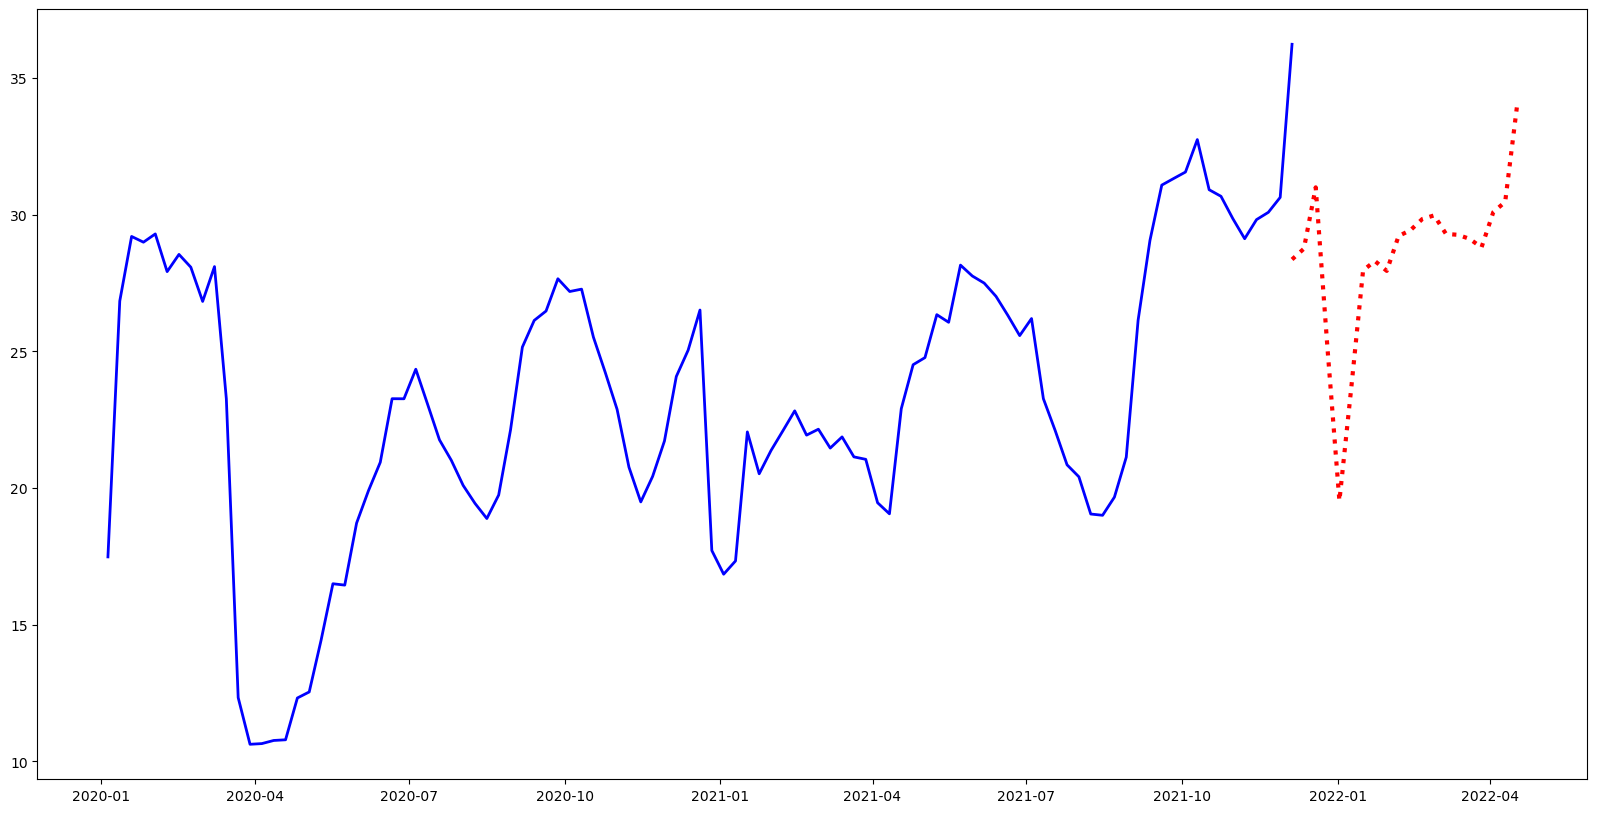

In [10]:
# Reset indexes
df_final.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)

# Resample the data to a weekly frequency and take the mean
weekly_average_train = df_final['congestion'].resample('W').mean()
weekly_average_test = df_test['xb_congestion'].resample('W').mean()

# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(weekly_average_train, color = 'b', lw=2)
plt.plot(weekly_average_test, color = 'r', lw=3, ls=':')
plt.show()

## Feature Importance

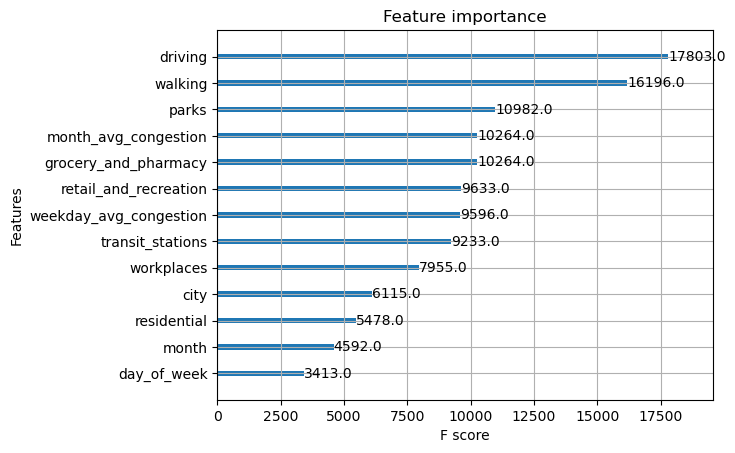

In [11]:
from xgboost import plot_importance

plot_importance(xb)
plt.show()

## Geographical Data

In [12]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable


In [13]:
!pip install geopy

Defaulting to user installation because normal site-packages is not writeable


In [14]:
import folium
import geopy

# Create a list of cities
cities = df_train.city.unique()

# Create a map centered on the average coordinates of the cities
map = folium.Map(location=[52, 20], zoom_start=4)

# Add markers for each city
for city in cities:
    # Use geopy library to get the coordinates of the city
    location = geopy.geocoders.Nominatim(user_agent="myGeocoder").geocode(city)
    folium.Marker(location=[location.latitude, location.longitude], popup=city).add_to(map)

# Show the map
map

# Other Unsuccessful Variants of The Model
## Unchosen Variables
#### MAE Scores: 6.72 - 7.24

In [15]:
# Read the train csv file
df_train = pd.read_csv('train.csv', parse_dates=['date'])

# Add the precipitation column
precipitation = pd.read_csv('percipitation.csv', parse_dates=['date'])
precipitation = precipitation.rename(columns={'City': 'city'})
df_train = pd.merge(df_train, precipitation, on=['date', 'city'], how='left')

# Drop transit column
df_nonas = df_train.drop('transit', axis = 1)

# Fill NAs with 0s
df_nonas = df_nonas.fillna(0)
df_nonas['percipitation'] = df_nonas['percipitation'].fillna(-9999)

# Drop outliers
df_nooutliers = drop_outliers(df_nonas, 'congestion')
                                              
# Creating new columns 

df_final = df_nooutliers.assign(
    month_and_day=df_nonas['date'].dt.strftime('%m-%d'),
    month=df_nonas['date'].dt.strftime('%m'),
    day_of_week=df_nonas['date'].dt.strftime('%A')
)

# Average congestion for the weekday in the city
df_final['weekday_avg_congestion'] = df_final.groupby(['city', df_final['date'].dt.strftime('%A')])['congestion'].transform('mean')

# Average congestion for the same month (current and previous) in the city
df_final['month_avg_congestion'] = df_final.groupby(['city', df_final['date'].dt.strftime('%m')])['congestion'].transform('mean')

# Median congestion for the weekday in the city
df_final['weekday_med_congestion'] = df_final.groupby(['city', df_final['date'].dt.strftime('%A')])['congestion'].transform('median')

# Median congestion for the same month (current and previous) in the city
df_final['month_med_congestion'] = df_final.groupby(['city', df_final['date'].dt.strftime('%m')])['congestion'].transform('median')

# Pondered sum of other recreational factors (mean)
df_final['pondered_avg_of_factors'] = df_final.groupby(['city'])['retail_and_recreation'].transform('mean')*0.396263 + df_final.groupby(['city'])['transit_stations'].transform('mean')*0.358932 + df_final.groupby(['city'])['grocery_and_pharmacy'].transform('mean')*0.340182 + df_final.groupby(['city'])['driving'].transform('mean')*0.310049

# Pondered sum of other recreational factors (median)
df_final['pondered_median_of_factors'] = df_final.groupby(['city'])['retail_and_recreation'].transform('median')*0.396263 + df_final.groupby(['city'])['transit_stations'].transform('median')*0.358932 + df_final.groupby(['city'])['grocery_and_pharmacy'].transform('median')*0.340182 + df_final.groupby(['city'])['driving'].transform('median')*0.310049

# Congestion volatility
df_final['congestion_change'] = df_final.groupby('city')['congestion'].pct_change()
city_std = df_final.groupby('city')['congestion_change'].std()
df_final = df_final.merge(city_std, on='city', suffixes=('', '_std')).drop('congestion_change', axis=1)

# List of cities with rivers
cities_with_rivers = ['Graz', 'Vienna', 'Brussels', 'Brno', 'Prague', 'Copenhagen',
                      'Budapest', 'Cork', 'Dublin', 'Bologna', 'Catania', 'Milan',
                      'Rome', 'Groningen', 'Krakow', 'Poznan', 'Lisbon', 'Porto',
                      'Bucharest', 'Barcelona', 'Madrid', 'Gothenburg', 'Malmo', 'Stockholm']

# Create a new column with 0 or 1 based on whether the city has a river or not
df_final['has_river'] = df_final['city'].isin(cities_with_rivers).astype(int)

# Dictionary to store the population of each city
population = {
    'Graz': 120000,
    'Vienna': 2000000,
    'Brussels': 1000000,
    'Charleroi': 50000,
    'Brno': 400000,
    'Prague': 1200000,
    'Copenhagen': 600000,
    'Tallinn': 40000,
    'Helsinki': 650000,
    'Grenoble': 150000,
    'Lille': 250000,
    'Paris': 2200000,
    'Berlin': 3500000,
    'Bremen': 520000,
    'Cologne': 1000000,
    'Dresden': 600000,
    'Munich': 1500000,
    'Athens': 700000,
    'Budapest': 2000000,
    'Cork': 150000,
    'Dublin': 500000,
    'Bologna': 400000,
    'Catania': 350000,
    'Milan': 1000000,
    'Rome': 3000000,
    'Eindhoven': 200000,
    'Groningen': 180000,
    'Krakow': 800000,
    'Poznan': 600000,
    'Lisbon': 600000,
    'Porto': 400000,
    'Bucharest': 2000000,
    'Alicante': 300000,
    'Barcelona': 3000000,
    'Madrid': 5000000,
    'Malaga': 600000,
    'Seville': 800000,
    'Gothenburg': 900000,
    'Malmo': 600000,
    'Stockholm': 1000000
}

# Create a new column with the population of each city
df_final['population_2020'] = df_final['city'].map(population)

df_final

,country,city,date,congestion,driving,walking,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,...,day_of_week,weekday_avg_congestion,month_avg_congestion,weekday_med_congestion,month_med_congestion,pondered_avg_of_factors,pondered_median_of_factors,congestion_change_std,has_river,population_2020
0,Austria,Graz,2019-12-30,23,0.00,0.00,0.0,0.0,0.0,0.0,...,Monday,27.079208,22.939394,29.0,22.0,-21.376469,-17.272945,0.879244,1,120000
1,Austria,Graz,2019-12-31,12,0.00,0.00,0.0,0.0,0.0,0.0,...,Tuesday,27.425743,22.939394,29.0,22.0,-21.376469,-17.272945,0.879244,1,120000
2,Austria,Graz,2020-01-01,8,0.00,0.00,0.0,0.0,0.0,0.0,...,Wednesday,28.740000,20.457627,30.0,20.0,-21.376469,-17.272945,0.879244,1,120000
3,Austria,Graz,2020-01-02,20,0.00,0.00,0.0,0.0,0.0,0.0,...,Thursday,27.212121,20.457627,28.0,20.0,-21.376469,-17.272945,0.879244,1,120000
4,Austria,Graz,2020-01-03,20,0.00,0.00,0.0,0.0,0.0,0.0,...,Friday,27.112245,20.457627,28.0,20.0,-21.376469,-17.272945,0.879244,1,120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27532,Sweden,Stockholm,2021-11-26,38,49.25,69.41,-8.0,-7.0,4.0,-26.0,...,Friday,26.591837,27.850000,29.0,27.0,-22.018999,-22.364900,0.355349,1,1000000
27533,Sweden,Stockholm,2021-11-27,28,53.02,77.35,-1.0,-5.0,8.0,-18.0,...,Saturday,17.434343,27.850000,18.0,27.0,-22.018999,-22.364900,0.355349,1,1000000
27534,Sweden,Stockholm,2021-11-28,27,38.09,10.11,-2.0,-8.0,-2.0,-24.0,...,Sunday,16.404040,27.850000,16.0,27.0,-22.018999,-22.364900,0.355349,1,1000000
27535,Sweden,Stockholm,2021-11-29,34,24.19,8.37,-14.0,-5.0,-5.0,-34.0,...,Monday,26.663366,27.850000,28.0,27.0,-22.018999,-22.364900,0.355349,1,1000000


In [16]:
df_final.corr()['congestion'].sort_values(ascending=False, key = abs)

congestion                    1.000000
weekday_avg_congestion        0.733296
weekday_med_congestion        0.728938
month_avg_congestion          0.593087
month_med_congestion          0.563065
retail_and_recreation         0.395104
transit_stations              0.356079
grocery_and_pharmacy          0.343934
driving                       0.327545
walking                       0.280562
percipitation                -0.170008
residential                  -0.164411
has_river                     0.098838
pondered_avg_of_factors      -0.097877
parks                         0.081467
pondered_median_of_factors   -0.080577
workplaces                    0.072814
congestion_change_std         0.049173
population_2020               0.042000
commercial                   -0.003164
other                        -0.000981
utilities                    -0.000397
Name: congestion, dtype: float64

## Unchosen Hybrid Model
#### MAE Score: 14.13

Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. Hence, I decided to create a "hybrid" forecaster that combines complementary learning algorithms and let the strengths of one make up for the weakness of the other.

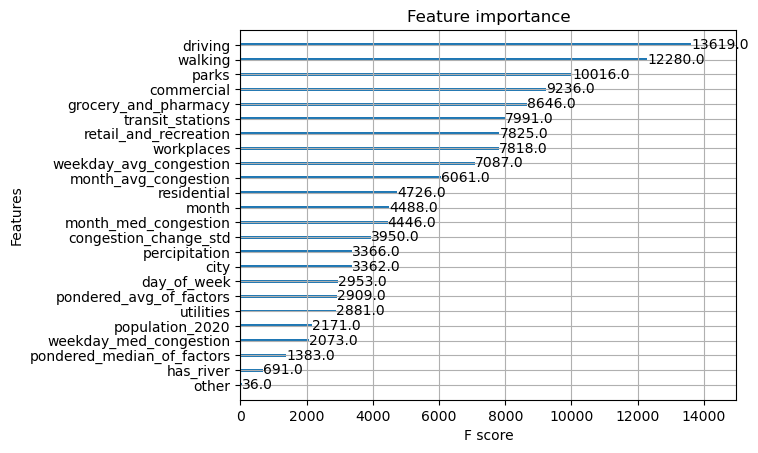

In [17]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split

df_final['city'] = df_final['city'].astype('category').cat.codes
df_final['month'] = df_final['month'].astype('int')
df_final['day_of_week'] = df_final['day_of_week'].astype('category').cat.codes

y_train = df_final[['date', 'congestion']].set_index('date')

# Create trend features
dp = DeterministicProcess(
    index=df_final.date,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)

X_train = dp.in_sample()  # features for the training data

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_fit = y_fit.values.reshape(-1,)

# In this case, we let all numerical variables in just to see their hypothetical weight on the model and compare them
# to their correlation with congestion (previously calculated).
X_train = df_final.drop(['country', 'congestion', 'date', 'month_and_day'], axis = 1)
y_train = df_final['congestion'].values.reshape(-1,)

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train CGBoost for residuals
xb = XGBRegressor(max_depth=45, 
                  learning_rate=0.1, 
                  n_estimators=100, 
                  min_child_weight=15,
                  gamma=0,
                  subsample=1.0,
                  colsample_bytree=0.8,
                  colsample_bylevel=1.0                  
                )

xb.fit(X_train, y_resid)

plot_importance(xb)
plt.show()

## Model Parameters Optimization
GridSearchCV is a scikit-learn function that performs an exhaustive search over a specified parameter grid for an estimator (e.g. a classifier or regressor). It trains and evaluates the estimator multiple times, each time using different combinations of parameter values from the grid, and returns the best performing combination of parameters.

The main advantage of using GridSearchCV is that it saves time and effort compared to manually tuning the parameters of an estimator one by one. It also helps to ensure that all possible combinations of parameters are considered, which can prevent the user from missing an optimal solution. 
### Decision Tree Regressor
#### MAE Score (before feature engineering): 8.99

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

models = {
    'dt': DecisionTreeRegressor()
}

param_grids = {
    'dt': {
        'max_depth': [60],
        'min_samples_split': [60],
        'min_samples_leaf': [50],
        'max_features': [0.9],
        'max_leaf_nodes': [None],
        'ccp_alpha': [0]
    }
}

best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv = 5, n_jobs=-1, verbose=3)
    best_model = grid_search.fit(X, y)
    best_models[name] = best_model
    print(f"Mejores parámetros para el modelo {name}: {grid_search.best_params_}")
    print(f"Score para el modelo {name}: {grid_search.best_score_}")

### Random Forest Regressor
#### MAE Score (before feature engineering): 7.77

In [ ]:
from sklearn.ensemble import RandomForestRegressor

models = {
    'rf': RandomForestRegressor()
}

param_grids = {
    'rf': {
        'n_estimators': [300],
        'max_depth': [65],
        'min_samples_split': [60],
        'min_samples_leaf': [45],
        'max_features': [0.9],
        'max_leaf_nodes': [None],
        'ccp_alpha': [0]
    }
}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv = 5, n_jobs=-1, verbose=3)
    best_model = grid_search.fit(X, y)
    best_models[name] = best_model
    print(f"Mejores parámetros para el modelo {name}: {grid_search.best_params_}")
    print(f"Score para el modelo {name}: {grid_search.best_score_}")

### XGBoost Regressor
#### MAE Score (before feature engineering): 6.72

In [ ]:
from xgboost import XGBRegressor

models = {
    'xb': XGBRegressor()
}

param_grids = {
    'xb': {
        'max_depth': [45],
        'learning_rate': [0.1],
        'n_estimators': [100],
        'min_child_weight': [15],
        'gamma': [0],
        'subsample': [1.0],
        'colsample_bytree': [0.8],
        'colsample_bylevel': [1.0]
    }
}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1, verbose=3)
    best_model = grid_search.fit(X, y)
    best_models[name] = best_model
    print(f"Mejores parámetros para el modelo {name}: {grid_search.best_params_}")
    print(f"Score para el modelo {name}: {grid_search.best_score_}")